# Cotton Disease Classification using DenseNet 169

As specified in the question, cotton dataset was used which consists of 2204 training (+ validation) samples and 106 testing samples.
Each image is associated with a label as specified below

| Class | Label                 |
| ----- | --------------------- |
| 0     | Diseased Cotton Leaf  |
| 1     | Diseased Cotton Plant |
| 2     | Fresh Cotton Leaf     |
| 3     | Fresh Cotton Plant    |

## Importing required modules

In [ ]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.ion()

import torch # PyTorch
from torch import nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset # Dataset Helpers
import torch.optim as optim # NN Optimizers

from torchvision.io import read_image
from torchvision import transforms # Transformations for input images
import torchvision.models as models # Pretrained CNN Models

## Define Hyperparameters

In [ ]:
num_epochs = 5
learning_rate = 0.001
momentum = 0.9
batch_size = 16
normalization_mean = np.array([0.485, 0.456, 0.406])
normalization_std = np.array([0.229, 0.224, 0.225])

### Check if we can run on GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Pre Processing

### 1. Define the Output Classes

In [ ]:
CLASSES = ['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant']
for c, i in enumerate(CLASSES):
    print(c, i)

0 diseased cotton leaf
1 diseased cotton plant
2 fresh cotton leaf
3 fresh cotton plant


### 2. Construct Dataset

#### 2.1 Construct a Pandas DataFrame from the Image Files

In [ ]:
def get_data_frame(type="train"):
    data = {'image': [], 'label': []}
    for i, c in enumerate(CLASSES):
        for dirname, _, filenames in os.walk(f'/kaggle/input/cotton-disease-dataset/Cotton Disease/{type}/{c}'):
            for filename in filenames:
                data['image'].append(filename)
                data['label'].append(i)
    
    df = pd.DataFrame(data=data)
    return df

#### 2.2 A Pytorch Dataset class for reading and processing the images

Here we apply a transformation on the images by performing the following

1. **Resize to 256x256** and **CenterCrop to 224x224** so that every image is of the same dimension.
2. **Normalize the R, G, B Channels** of the image to assist in training.

In [ ]:
class CottonDiseaseDataset(Dataset):
    def __init__(self, type="train", img_dir="/kaggle/input/cotton-disease-dataset/Cotton Disease"):
        # Get the Dataframe and Shuffle
        self.type = type
        self.df = get_data_frame(type)
        self.img_dir = img_dir
        
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=normalization_mean, std=normalization_std)
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img_path = os.path.join(self.img_dir, self.type, CLASSES[row['label']], row['image'])
        img = read_image(img_path).type(torch.FloatTensor) / 255
        
        label = row['label']
        
        img = self.transform(img)
        label = torch.LongTensor((label,))
        
        return img, label

#### 2.3 Define DataLoaders for Batching and shuffling available data

The images are shuffled randomly and batched to ensure proper learning.

In [ ]:
train_dataset = CottonDiseaseDataset('train')
val_dataset = CottonDiseaseDataset('val')

train_dataset = ConcatDataset((train_dataset, val_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CottonDiseaseDataset('test')
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataset), len(test_dataset))

2204 106


#### Testing the Dataset by Generating Examples

In [ ]:
# Plot image helper function
def plot_image(axis, image, label, predicted_label=None):
    img = image.cpu().numpy()
    img = img * normalization_std.reshape((3, 1, 1)) + normalization_mean.reshape((3, 1, 1))
    img = img.transpose([1,2,0])
    
    axis.imshow(img)
    axis.text(5, 5, CLASSES[label], bbox={'facecolor': 'white', 'pad': 10})
    
    if predicted_label != None:
        axis.text(5, 55, "predicted: " + CLASSES[predicted_label], bbox={'facecolor': 'white', 'pad': 10})

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


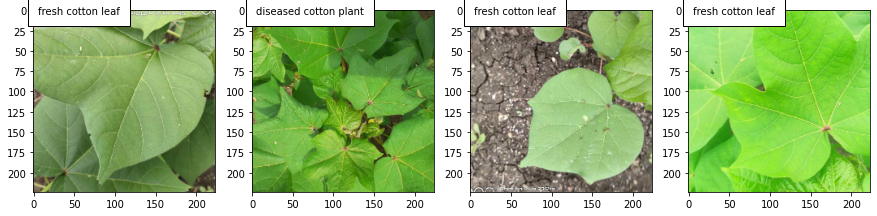

In [ ]:
data = next(iter(train_dataloader))

train_features, train_labels = data[0].to(device), data[1].to(device).squeeze()

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

figure, axes = plt.subplots(1, 4, figsize=(15, 15))

for i, ax in enumerate(axes):
    plot_image(ax, train_features[i], train_labels[i])

## Model

### 1. Pre Trained Model

We download a pretrained model of DenseNet169 using ```torchvision```

In [ ]:
pretrained_model = models.densenet169(pretrained=True)
pretrained_model.eval();

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]

### 2. Wrapper model with Dense Layer and Softmax

We add our transfer learning layers to the model by adding a ```nn.Linear``` linear layer to map the output of the CNN to the Number of Classes that we have (4)

In [ ]:
cnn = pretrained_model
cotton_model = nn.Sequential(
    cnn,
    nn.ReLU(),
    nn.Linear(1000, len(CLASSES))
).to(device)

### 3. Testing the Model with an example

In [ ]:
data = next(iter(test_dataloader))

test_features, test_labels = data[0].to(device), data[1].to(device).squeeze()

out = cotton_model(train_features)
print(out.shape)

torch.Size([16, 4])


## Training

### 1. Define Loss Function and Optimizer

We use the **CrossEntroyLoss** function as it is a **Multiclass Classification** problem. A seperate **Softmax** layer is not applied as the CrossEntropyLoss function does this automatically.

We use the standard **Stochastic Gradient Descent (SGD)** Optimizer to optimize our model.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cotton_model.parameters(), lr=learning_rate, momentum=momentum)

### 2. Train the Network

The model is trained for ```num_epochs``` epochs, the loss is calculated and the network is optimized.

In [ ]:
# Train for {num_epochs} epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Loop through the dataset
    for i, data in enumerate(train_dataloader):
        
        # Get a data point
        features, labels = data[0].to(device), data[1].to(device).squeeze()
        
        # Zero the optimizer, parameter gradients
        optimizer.zero_grad()
        
        # Forward Propogation
        outputs = cotton_model(features)
        
        # Calculate loss
        loss = criterion(outputs, labels.squeeze())
        
        # Backpropagate and Optimize
        loss.backward()
        optimizer.step()
        
        # Print Statistics
        running_loss += loss.item()
        if i % 100 == 99: # Print every 100 mini batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0

[1,   100] loss: 1.468
[2,   100] loss: 1.014
[3,   100] loss: 0.452
[4,   100] loss: 0.211
[5,   100] loss: 0.120


### Save the Weights

In [ ]:
PATH = '/kaggle/working/cotton_model.pth'
torch.save(cotton_model.state_dict(), PATH)

## Testing

### Check Accuracy

We iterate through the ```test_dataset``` and calculate the accuracy of our model.

In [ ]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device).squeeze()
        
        labels = labels.squeeze()
        
        # calculate outputs by running images through the network
        outputs = cotton_model(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

Accuracy of the network on the 106 test images: 100 %


### Try some examples

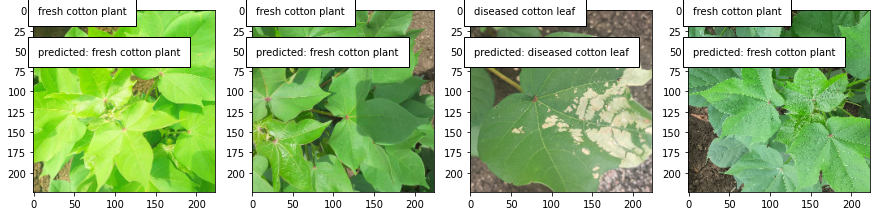

In [ ]:
data = next(iter(test_dataloader))

test_features, test_labels = data[0].to(device), data[1].to(device).squeeze()

# calculate outputs by running images through the network
test_outputs = cotton_model(test_features)

# the class with the highest energy is what we choose as prediction
_, predicted = torch.max(test_outputs.data, 1)

figure, axes = plt.subplots(1, 4, figsize=(15, 15))
 
for i, ax in enumerate(axes):
    plot_image(ax, test_features[i], test_labels[i], predicted[i])

## Results

We obtained the following results after performing **Multi Class Classification** on the **Cotton Disease Dataset** using a **transfer learning** approach on **DenseNet169**

- The following hyperparameters were found to produce the best results:

| Column 1      | Column 2 |
| ------------- | -------- |
| Epochs        | 5        |
| Batch size    | 16       |
| Momentum      | 0.9      |
| Learning Rate | 0.001    |
    
- The decrease in loss function with each epoch is as follows:

| Epoch | Loss  |
| ----- |:-----:|
| 1     | 1.391 |
| 2     | 0.961 |
| 3     | 0.494 |
| 4     | 0.341 |
| 5     | 0.246 |

- The model was tested on 106 test images and was found to have an accuracy of **100%**.